In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier

import xgboost as xgb

from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA



In [2]:
# 데이터 불러오기
df = pd.read_csv('../data/df.csv')

In [3]:
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금
0,165,2059,79.97,0,4,26,1.5,117.6,44000
1,165,2059,79.97,0,3,26,1.5,117.6,42000
2,165,453,133.46,0,8,23,1.5,117.6,80000
3,165,453,104.43,0,6,23,1.5,117.6,52000
4,165,453,104.43,0,3,23,1.5,117.6,55000


In [4]:
# 보증금 분산 정도 확인하기
# 선형회귀의 가정은 데이터의 분포가 정규분포를 이루고 있다는 것

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

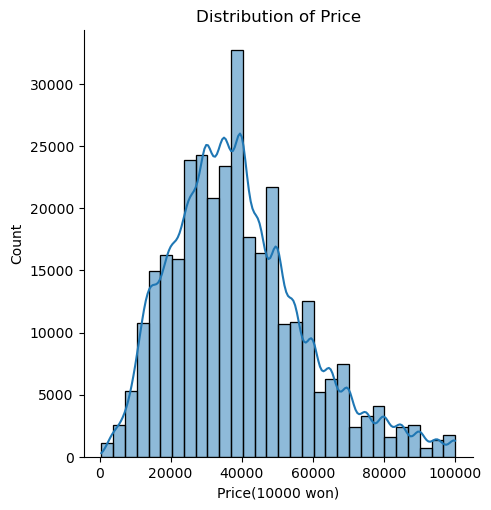

In [5]:
plt.figure()
sns.displot(df['보증금'], bins=30, kde=True)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

In [6]:
# 많이는 아니지만 왼쪽으로 왜도가 치우침
# 로그로 변환 해보기

In [7]:
# 가격 로그 변환 후 원래 가격 따로 저장
df['log_price'] = np.log1p(df['보증금'])
real_price = df['보증금'] # 원래 가격

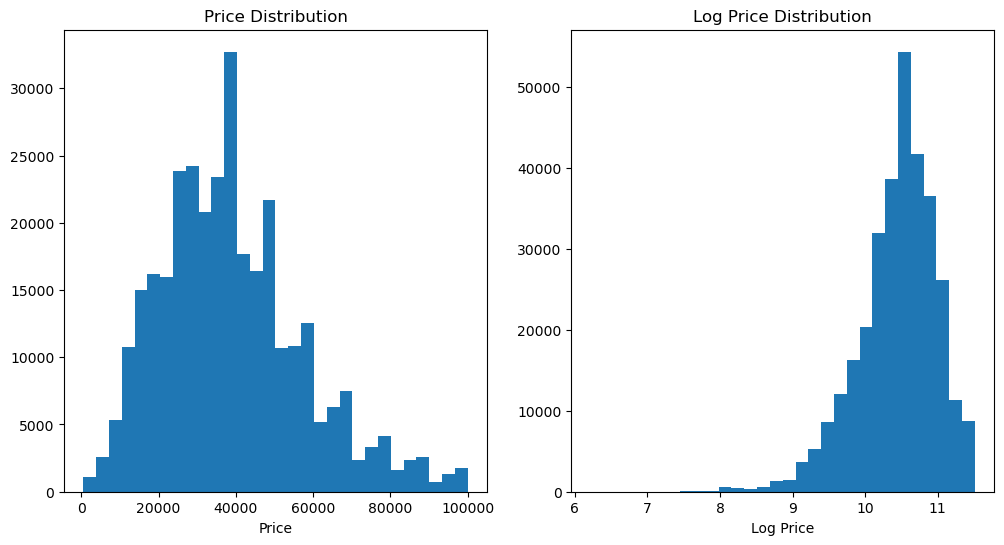

In [8]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

In [9]:
# 로그변환했을 때 오른쪽으로 더 치우침

In [10]:
# 제곱근 변환 후 원래 가격 따로 저장
df['sqrt_price'] = np.sqrt(df['보증금'])

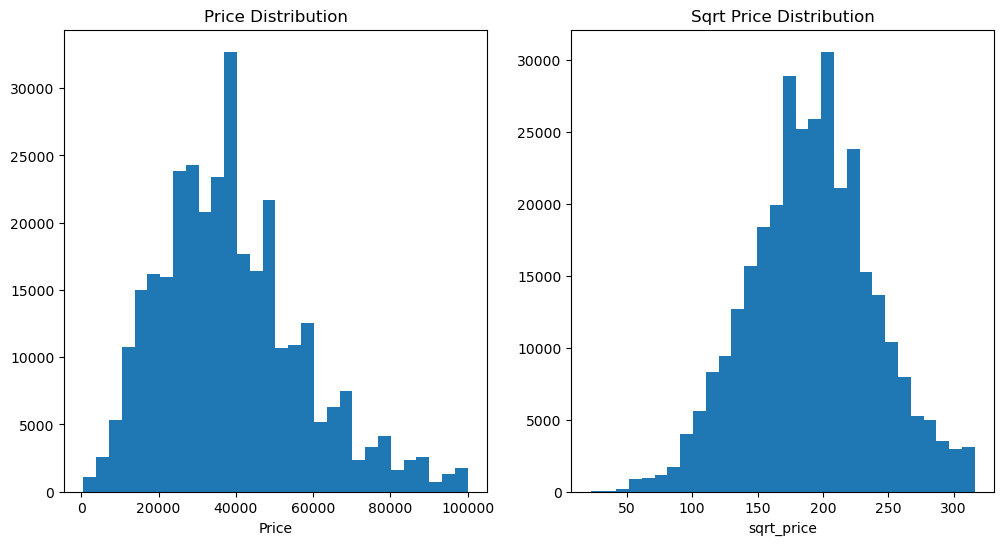

In [11]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(df['sqrt_price'], bins=30)
ax2.set_title('Sqrt Price Distribution')
ax2.set_xlabel('sqrt_price')

plt.show()

In [12]:
#제곱근으로 했을때 훨씬 정규화를 이루는 것을 알 수 있음

In [13]:
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,log_price,sqrt_price
0,165,2059,79.97,0,4,26,1.5,117.6,44000,10.691968,209.761770
1,165,2059,79.97,0,3,26,1.5,117.6,42000,10.645449,204.939015
2,165,453,133.46,0,8,23,1.5,117.6,80000,11.289794,282.842712
3,165,453,104.43,0,6,23,1.5,117.6,52000,10.859018,228.035085
4,165,453,104.43,0,3,23,1.5,117.6,55000,10.915107,234.520788


In [14]:
# 데이터 정리하기
df.drop('log_price', axis=1, inplace=True)

In [15]:
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,sqrt_price
0,165,2059,79.97,0,4,26,1.5,117.6,44000,209.761770
1,165,2059,79.97,0,3,26,1.5,117.6,42000,204.939015
2,165,453,133.46,0,8,23,1.5,117.6,80000,282.842712
3,165,453,104.43,0,6,23,1.5,117.6,52000,228.035085
4,165,453,104.43,0,3,23,1.5,117.6,55000,234.520788


In [16]:
# 면적 확인하기

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

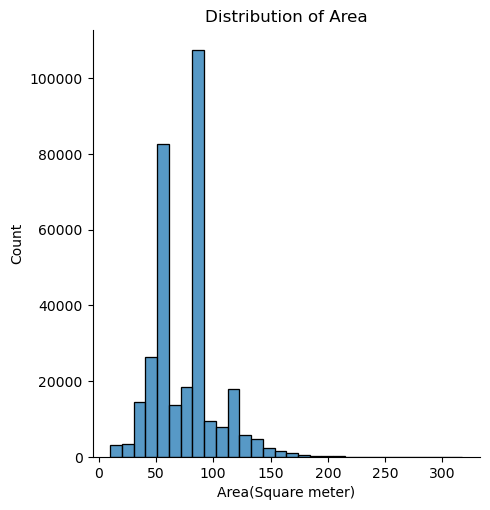

In [17]:
plt.figure()
sns.displot(df['전용면적'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

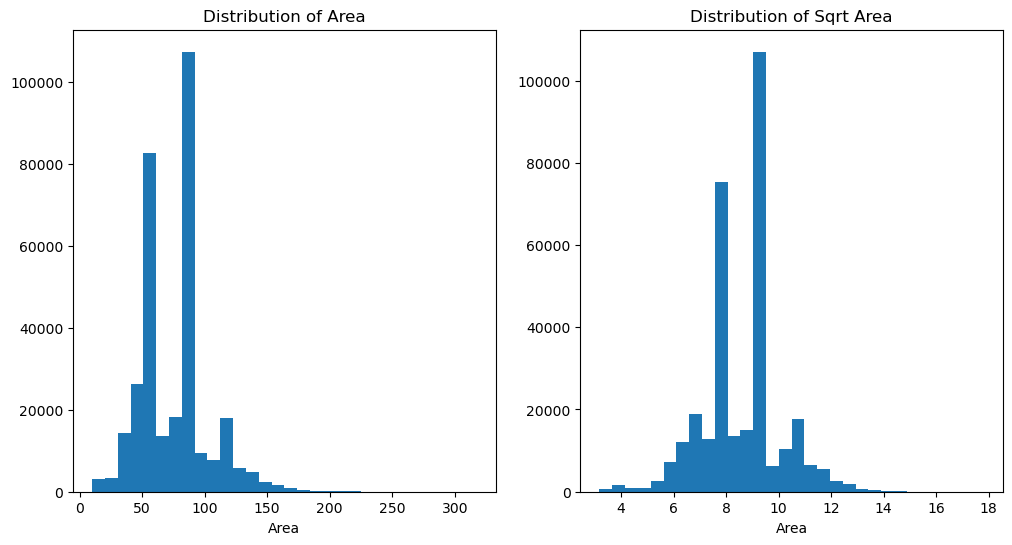

In [18]:
# 제곱근
df['sqrt_area'] = np.sqrt(df['전용면적'])
real_area = df['전용면적']

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(df['sqrt_area'], bins=30)
ax2.set_title('Distribution of Sqrt Area')
ax2.set_xlabel('Area')

plt.show()

In [19]:
df.head()

,동,단지명,전용면적,계약년월,층,건축년도,금리,부동산소비심리,보증금,sqrt_price,sqrt_area
0,165,2059,79.97,0,4,26,1.5,117.6,44000,209.761770,8.942595
1,165,2059,79.97,0,3,26,1.5,117.6,42000,204.939015,8.942595
2,165,453,133.46,0,8,23,1.5,117.6,80000,282.842712,11.552489
3,165,453,104.43,0,6,23,1.5,117.6,52000,228.035085,10.219100
4,165,453,104.43,0,3,23,1.5,117.6,55000,234.520788,10.219100


In [20]:
# 자료 정리하기
df.drop('전용면적', axis=1, inplace=True)
df.drop('보증금', axis=1, inplace=True)

df= df[['동', '단지명', '계약년월', '층', '건축년도', '금리', '부동산소비심리', 'sqrt_area', 'sqrt_price']]

In [21]:
df.head()

,동,단지명,계약년월,층,건축년도,금리,부동산소비심리,sqrt_area,sqrt_price
0,165,2059,0,4,26,1.5,117.6,8.942595,209.761770
1,165,2059,0,3,26,1.5,117.6,8.942595,204.939015
2,165,453,0,8,23,1.5,117.6,11.552489,282.842712
3,165,453,0,6,23,1.5,117.6,10.219100,228.035085
4,165,453,0,3,23,1.5,117.6,10.219100,234.520788


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320979 entries, 0 to 320978
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   동           320979 non-null  int64  
 1   단지명         320979 non-null  int64  
 2   계약년월        320979 non-null  int64  
 3   층           320979 non-null  int64  
 4   건축년도        320979 non-null  int64  
 5   금리          320979 non-null  float64
 6   부동산소비심리     320979 non-null  float64
 7   sqrt_area   320979 non-null  float64
 8   sqrt_price  320979 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 22.0 MB


# 데이터 정규화하기

In [23]:
# MinMaxScaler 클래스 생성
scaler = MinMaxScaler()

# MinMaxScaler 클래스의 fit_transform() 메서드 사용 데이터 정규화
normalized_data = scaler.fit_transform(df)

# 정규화된 데이터, 데이터 프레임으로 다시 변환
normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

In [24]:
normalized_df.head()

,동,단지명,계약년월,층,건축년도,금리,부동산소비심리,sqrt_area,sqrt_price
0,0.498489,0.310464,0.0,0.058824,0.456140,0.5,0.589552,0.393781,0.637707
1,0.498489,0.310464,0.0,0.044118,0.456140,0.5,0.589552,0.393781,0.621296
2,0.498489,0.068305,0.0,0.117647,0.403509,0.5,0.589552,0.572113,0.886394
3,0.498489,0.068305,0.0,0.088235,0.403509,0.5,0.589552,0.481004,0.699889
4,0.498489,0.068305,0.0,0.044118,0.403509,0.5,0.589552,0.481004,0.721959


In [25]:
 ndf = normalized_df.copy()

# 데이터  나누기

In [26]:
X = ndf.iloc[:, :-1]
y = ndf.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
print(X_train.shape, y_train.shape)

(256783, 8) (256783,)


In [28]:
# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(256783, 8) (64196, 8)
(231104, 8) (25679, 8)


# DecisionTreeRegresson

In [29]:
# 클래스 생성
regressor = DecisionTreeRegressor(max_depth=23, min_samples_split=10, min_samples_leaf=15, max_features='auto', criterion='squared_error')

# 학습
regressor.fit(X_train, y_train)

# 예측값
y_pred = regressor.predict(X_test)

# RMSE를 계산(낮을 수록 정확함)
rmse = mean_squared_error(y_test, y_pred)
print('rmse :',rmse)

# R^2을 계산(R^2가 1에 가까울수록 모델이 데이터를 잘 설명)
r2 = r2_score(y_test, y_pred)
print('r2 :',r2)

# MAE를 계산(MAE가 낮을수록 예측값과 실제값이 가까워짐)
mae = mean_absolute_error(y_test, y_pred)
print('mae :',mae)

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


rmse : 0.002474222199329261
r2 : 0.906081351967796
mae : 0.029049021210036222


In [30]:
# 크로스 밸리데이션을 수행합니다.
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print(scores)

C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\tjoeun\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

[0.90375132 0.90173307 0.9024679  0.90009398 0.90185685]


In [ ]:
# rmse : 0.002474222199329261 : 정확도 괜찮음
# r2 : 0.906081351967796 : 데이터를 잘 반영하고 있음
# mae : 0.029049021210036222 : 성능 많이 훌륭하진 않지만 준수한 모델
# cv : [0.90375132 0.90173307 0.9024679  0.90009398 0.90185685] : 과대적합x

In [35]:
#역정규화...
inverse_normalized_values = scaler.inverse_transform(normalized_df)
inverse_normalized_df = pd.DataFrame(inverse_normalized_values, columns=df.columns)
inverse_normalized_df.head()

,동,단지명,계약년월,층,건축년도,금리,부동산소비심리,sqrt_area,sqrt_price
0,165.0,2059.0,0.0,4.0,26.0,1.5,117.6,8.942595,209.761770
1,165.0,2059.0,0.0,3.0,26.0,1.5,117.6,8.942595,204.939015
2,165.0,453.0,0.0,8.0,23.0,1.5,117.6,11.552489,282.842712
3,165.0,453.0,0.0,6.0,23.0,1.5,117.6,10.219100,228.035085
4,165.0,453.0,0.0,3.0,23.0,1.5,117.6,10.219100,234.520788


In [ ]:
plt.plot(inverse_normalized_values)
plt.show()

In [ ]:
# 시각화 해보기

In [31]:
y_actual = ndf.iloc[:, -1]
y_actual = pd.DataFrame(y_actual)

y_actual['계약년월'] = ndf['계약년월']

y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred)

y_pred_avg = y_pred.groupby('계약년월').mean()
y_actual_avg = y_actual.groupby('계약년월').mean()

KeyError: '계약년월'

In [ ]:
# 예측값과 실제값을 그래프로 그립니다.
plt.plot(y_pred_avg, label='predict_price')
plt.plot(y_actual_avg, label='real_price')
plt.xlabel('contract_month')
plt.ylabel('price')
plt.legend()
plt.show()

# DecisionTreeRegresson

In [ ]:
# 클래스 생성
regressor = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50, min_samples_leaf=5, random_state=1, n_jobs=-1)

# 모델 학습
regressor.fit(X_train, y_train)

# 예측값
y_pred = regressor.predict(X_test)

# RMSE 계산
rmse = mean_squared_error(y_test, y_pred)
print(rmse)
